In [1]:
from glob import glob
import sys
import os
# import psutil
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest

# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

import mydef_GA

%matplotlib inline

In [2]:
## LDA analysis
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [3]:
from datetime import date
today = date.today().strftime("%Y%m%d")

In [8]:
script_dir = mydef_GA.script_dir

root_dir = mydef_GA.root_dir
fmri_dir = mydef_GA.fmri_dir
LSS_dir = mydef_GA.LSS_dir
stats_dir = mydef_GA.stats_dir
mask_dir = mydef_GA.mask_dir
dmn_dir = mydef_GA.dmn_dir
loc_dir = mydef_GA.loc_dir

In [9]:
subj_list = mydef_GA.subj_list
stage_list = mydef_GA.stage_list

In [10]:
## labeling with target position
# 1 - 5 - 25 - 21 - 1 - 25 - 5 - 21 - 25 - 1 - 21 - 5 - 1 - ...
##################
#  1  2  3  4  5 #
#  6  7  8  9 10 #
# 11 12 13 14 15 #
# 16 17 18 19 20 #
# 21 22 23 24 25 #
##################
target_pos = []

# with open(join(root_dir,'targetID.txt')) as file:
with open(join(script_dir,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
# target_path = list(range(1,13))*8

In [11]:
## background image
img_bg = join(mask_dir,'mni152_2009bet.nii.gz')

# ROI list

### Movement-related ROIs from localizer

In [12]:
## ROI
roi_imgs = {}
path_list = sorted(glob(join(mask_dir,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    roi_imgs[roi] = niimg.load_img(path)
roi_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7fba615c5370>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7fba615c53a0>,
 'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fba615c5cd0>,
 'n200_c1_R_SPL': <nibabel.nifti1.Nifti1Image at 0x7fba615c5b20>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fba616d8310>,
 'n200_c2_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fba616d86d0>,
 'n200_c3_R_MTG': <nibabel.nifti1.Nifti1Image at 0x7fba616d8850>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fba616d8e80>,
 'n200_c4_L_IFG': <nibabel.nifti1.Nifti1Image at 0x7fba616c4160>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fba616c4550>,
 'n200_c5_L_SPL': <nibabel.nifti1.Nifti1Image at 0x7fba616c4910>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fba72782c40>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fba615c5880>,
 'n200_c6_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fba91396e80>,
 'n200_c7_L_Thalamus': <nibabel

In [13]:
key_list = ['n200_c1_L_Postcentral'
            , 'n200_c2_R_CerebellumIV-V'
            , 'n200_c3_R_Postcentral'
            , 'n200_c4_L_Putamen'
            , 'n200_c5_R_SMA'
            , 'n200_c6_R_CerebellumVIIIb'
            , 'n200_c7_L_Thalamus']

n200_c1_L_Postcentral(n_voxles=200)
n200_c2_R_CerebellumIV-V(n_voxles=200)
n200_c3_R_Postcentral(n_voxles=200)
n200_c4_L_Putamen(n_voxles=200)
n200_c5_R_SMA(n_voxles=200)
n200_c6_R_CerebellumVIIIb(n_voxles=200)
n200_c7_L_Thalamus(n_voxles=200)


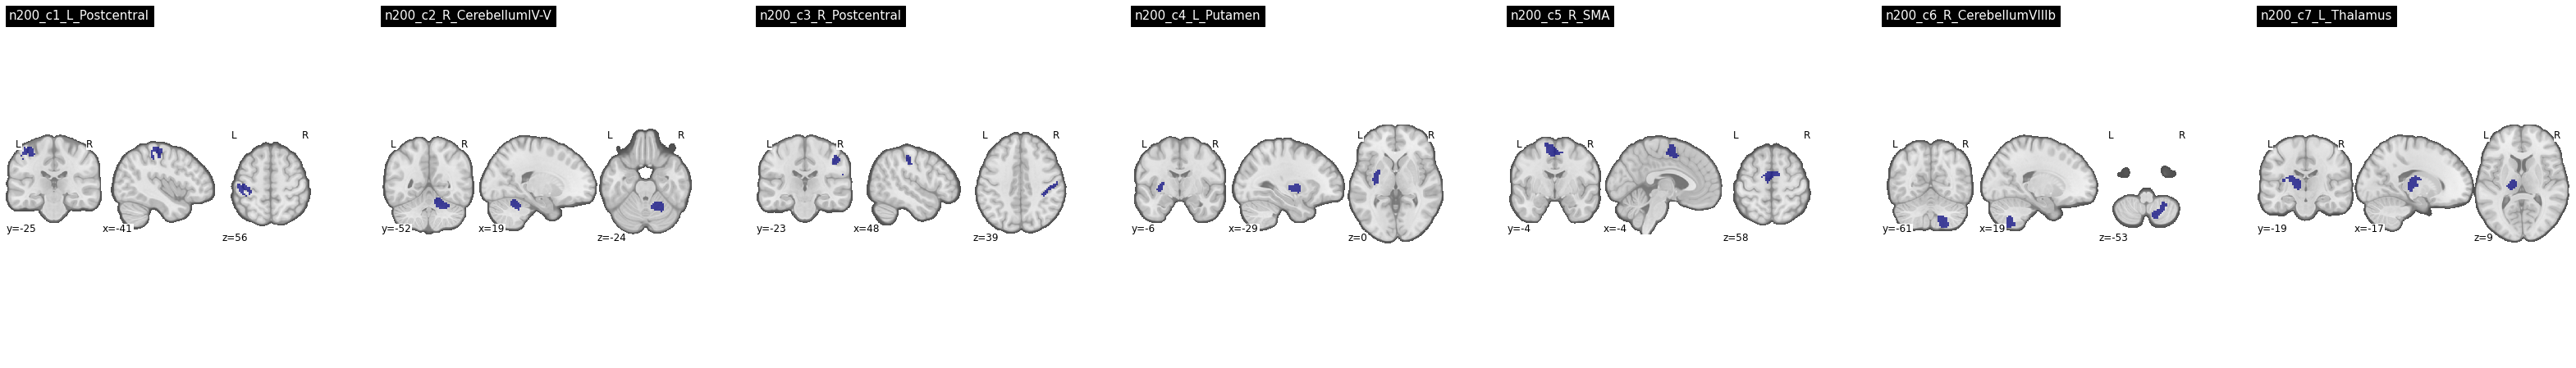

In [14]:
magn = 8   # a size of figures
ncol = 7   # a number of columns

nrow = len(key_list)//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))

for i, key in enumerate(key_list):
    img = roi_imgs[key]
#     print(key, end='\r')
    print('%s(n_voxles=%d)'%(key,img.get_fdata().sum()))
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=key
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i])

In [15]:
## ROI
roi_imgs = {}
path_list = sorted(glob(join(stats_dir,'GLM.move-stop','n*.nii.gz')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    roi_imgs[roi] = niimg.load_img(path)
roi_imgs

{'n200.L_Thalamus.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed2e20>,
 'n200.R_CerebellumVIIIb.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed2d60>,
 'n200.R_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed92e0>,
 'n201.L_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed9670>,
 'n202.R_CerebellumIV-V.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed9a00>,
 'n202.S_SMA.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed9df0>,
 'n225.L_Putamen.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72eda490>}

n200.L_Thalamus.nii.gz(n_voxles=1400)
n200.R_CerebellumVIIIb.nii.gz(n_voxles=1200)
n200.R_Postcentral.nii.gz(n_voxles=600)
n201.L_Postcentral.nii.gz(n_voxles=201)
n202.R_CerebellumIV-V.nii.gz(n_voxles=404)
n202.S_SMA.nii.gz(n_voxles=1010)
n225.L_Putamen.nii.gz(n_voxles=900)


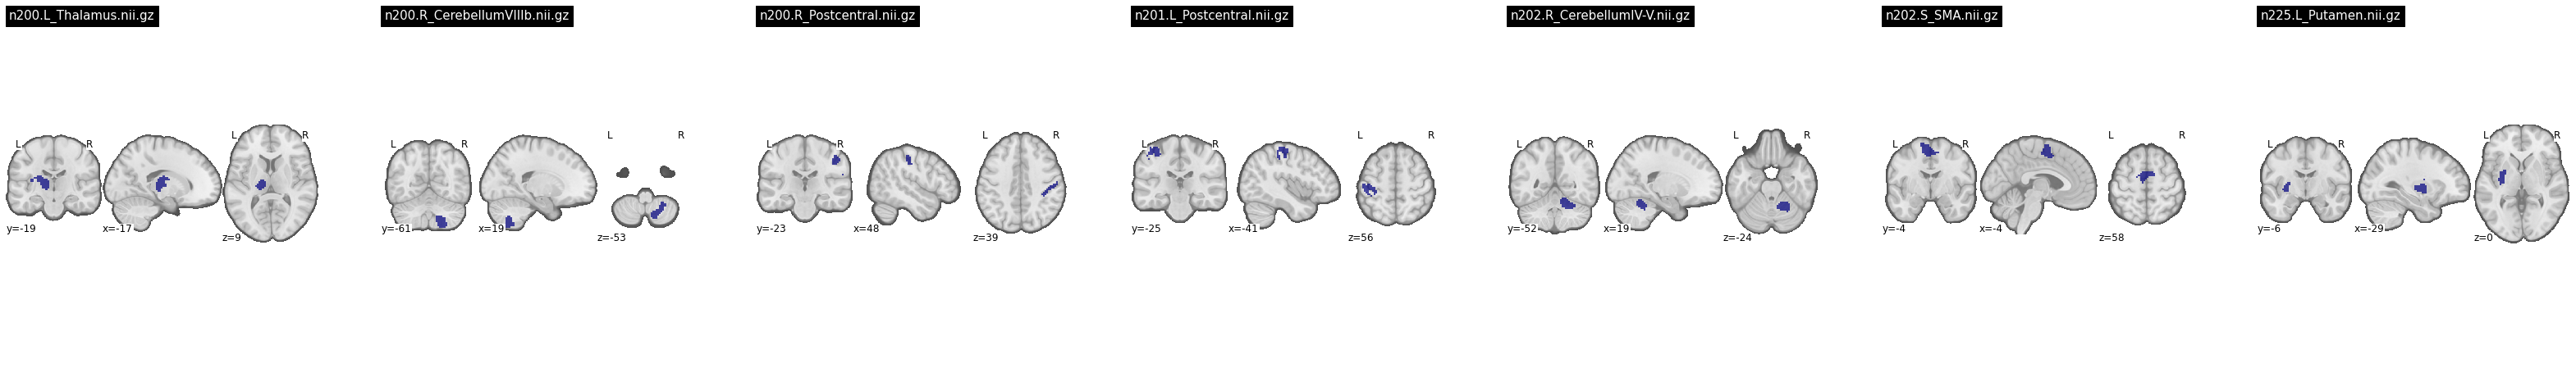

In [17]:
magn = 8   # a size of figures
ncol = 7   # a number of columns

nrow = len(key_list)//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))

for i, (key, img) in enumerate(roi_imgs.items()):
#     print(key, end='\r')
    print('%s(n_voxles=%d)'%(key,img.get_fdata().sum()))
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=key
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i])

### Default Mode Network

In [9]:
roi_imgs = {}
roi_names = []

## DMN regions(global)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(dmn_dir, name+'.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        roi_imgs[fname] = nilearn.image.load_img(path)
        roi_names.append(fname)
        
# ## DMN regions(detail)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(dmn_dir, name+'_*.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        roi_imgs[fname] = nilearn.image.load_img(path)
        roi_names.append(fname)

roi_imgs

{'Core': <nibabel.nifti1.Nifti1Image at 0x7fb1508c9e20>,
 'dMsub': <nibabel.nifti1.Nifti1Image at 0x7fb140f282e0>,
 'MTLsub': <nibabel.nifti1.Nifti1Image at 0x7fb140f28400>,
 'Core_PCC_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f286a0>,
 'Core_PCC_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f28a60>,
 'Core_aMPFC_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f28e20>,
 'Core_aMPFC_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f19280>,
 'dMsub_LTC_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f19610>,
 'dMsub_LTC_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f19a30>,
 'dMsub_TPJ_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f195e0>,
 'dMsub_TPJ_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f24160>,
 'dMsub_TempP_l_temp': <nibabel.nifti1.Nifti1Image at 0x7fb140f24520>,
 'dMsub_TempP_r_temp': <nibabel.nifti1.Nifti1Image at 0x7fb140f28340>,
 'dMsub_dMPFC': <nibabel.nifti1.Nifti1Image at 0x7fb140f283d0>,
 'MTLsub_HF_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f24130>,
 'MTLsub_HF_r': <nibabel.nifti1.Nifti1Image 

### Ventral visual stream (TT_Daemon, Brodmann Area)

In [10]:
roi_imgs = {}
path_list = glob(join(mask_dir, 'TT_Daemon', '*.brik1.BA???.*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[2]
    roi_imgs[fname] = nilearn.image.load_img(path)
roi_imgs

{'BA17L': <nibabel.nifti1.Nifti1Image at 0x7fb140f0f640>,
 'BA17R': <nibabel.nifti1.Nifti1Image at 0x7fb140f0f490>,
 'BA18L': <nibabel.nifti1.Nifti1Image at 0x7fb140f0fbe0>,
 'BA18R': <nibabel.nifti1.Nifti1Image at 0x7fb140f32a30>,
 'BA19L': <nibabel.nifti1.Nifti1Image at 0x7fb140f32d30>,
 'BA19R': <nibabel.nifti1.Nifti1Image at 0x7fb140f37370>,
 'BA20L': <nibabel.nifti1.Nifti1Image at 0x7fb140f37700>,
 'BA20R': <nibabel.nifti1.Nifti1Image at 0x7fb140f37a90>,
 'BA37L': <nibabel.nifti1.Nifti1Image at 0x7fb140f37eb0>,
 'BA37R': <nibabel.nifti1.Nifti1Image at 0x7fb140f3f070>,
 'BA38L': <nibabel.nifti1.Nifti1Image at 0x7fb140f3f580>,
 'BA38R': <nibabel.nifti1.Nifti1Image at 0x7fb140f3f910>}

### Fan280

In [11]:
fan_imgs={}
path_list = glob(join(mask_dir,'fan280','*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[-1]
    fan_imgs[fname] = nilearn.image.load_img(path)